Analysis script using MDAnalysis to perform h-bond analysis in between the Latrophilin and the Teneurin proteins

In [2]:
# importing MDAnalysis
import MDAnalysis as mda

# importing hbonds analysis from mda
from MDAnalysis.analysis import hbonds

#importing numpy
import numpy as np

# importing matplotlib to perform figures
import matplotlib.pyplot as plt


In [3]:
# load a pdb file (last frame of the trajectory)
u = mda.Universe("nowat.gro","nowat.xtc")

# define prot1 (index, resid, etc ..) see MDAnalysis language selection: https://www.mdanalysis.org/docs/documentation_pages/selections.html
sel_prot1 = "bynum 1:4074"

# define prot2 (index, resid, etc ..) see MDAnalysis language selection: https://www.mdanalysis.org/docs/documentation_pages/selections.html
sel_prot2 = "bynum 4075:8148"



In [4]:
#use MDanalysis HydrogenBondAnalysis to calculate the hbonds in between the 2 selections
hbonds_calc= hbonds.HydrogenBondAnalysis(u, sel_prot1, sel_prot2, distance=3.0, angle=120.0)
hbonds_calc.run()

HBonds frame  5000:  5001/5001 [100.0%]


In [6]:
from collections import defaultdict

# create a numpy array with the data extracted from hbond calculations - see block above
hbond_timeseries = np.array(hbonds_calc.timeseries)

percentage_traj_unused=0.2
nb_frames_unused=int(percentage_traj_unused*len(hbond_timeseries))
nb_frames_used=len(hbond_timeseries)-nb_frames_unused


# create dictionnaries for which the values are lists. 
# These will be filled with the name of atoms creating hbonds
dict_lect_res_hbond=defaultdict(list)
dict_ten_res_hbond=defaultdict(list)  



# iterate on the array to extract the res. as key and the atoms which can create hbonds as values 
for elt in hbond_timeseries[nb_frames_unused:]:
    list_res = elt
    
    for i in list_res:
        resA= int(i[2].split(':')[0][3:])
        resB= int(i[3].split(':')[0][3:])
        #print i
        #print (str(resA)+" create hbonds with "+str(resB))

        if int(i[0])<4074:
            dict_lect_res_hbond[resA].append(i[2].split(':')[1])
        else:
            dict_ten_res_hbond[resA].append(i[2].split(':')[1]) 
            
        if int(i[1])<4074:
            dict_lect_res_hbond[resB].append(i[3].split(':')[1])
        else:
            dict_ten_res_hbond[resB].append(i[3].split(':')[1]) 
       
# sort the 2 dictionnaries in function of the res nb
dict_lect_res_hbond_sorted= sorted({k: list(set(v)) for k, v in dict_lect_res_hbond.iteritems()}.iteritems(),key=lambda x: int(x[0]))
dict_ten_res_hbond_sorted= sorted({k: list(set(v)) for k, v in dict_ten_res_hbond.iteritems()}.iteritems(),key=lambda x: int(x[0]))

# create empty lists of atoms to be used to create the matrix
list_hbond_lect=[]
list_hbond_ten=[]
  
# concatenate res. nb and atom names to create a list unique identifiers    
for list_res_hbond in dict_lect_res_hbond_sorted:
    #print list_res_hbond[0]
    #print list_res_hbond[1]
    for atom_hbond in list_res_hbond[1]:
        atom_name=str(list_res_hbond[0])+":"+atom_hbond 
        list_hbond_lect.append(atom_name)

# concatenate res. nb and atom names to create a list unique identifiers       
for list_res_hbond in dict_ten_res_hbond_sorted:
    #print list_res_hbond[0]
    #print list_res_hbond[1]
    for atom_hbond in list_res_hbond[1]:
        atom_name=str(list_res_hbond[0])+":"+atom_hbond 
        list_hbond_ten.append(atom_name)        
        
        
#print list_hbond_lect
#print list_hbond_ten

# Create the interaction matrix for all the hbonds
w = len(list_hbond_ten)
h = len(list_hbond_lect)
Matrix_inter_hbond = np.zeros((w,h))

# fill the matrix 
for elt in hbond_timeseries[nb_frames_unused:]:
    list_res = elt
    
    for i in list_res:
        resA= i[2][3:]
        resB= i[3][3:]
        
        for j in range(0,len(list_hbond_ten)):
            for k in range(0,len(list_hbond_lect)):
                #print list_res_lect_int01[j]
                #print(list_res_ten_int01[j])   
                if(list_hbond_ten[j]==resA and list_hbond_lect[k]==resB):
                    #print(list_res_ten_int01_sorted[j])
                    #print(list_res_lect_int01_sorted[k])
                    Matrix_inter_hbond[j][k] =  Matrix_inter_hbond[j][k]+1
                    break
                if(list_hbond_ten[j]==resB and list_hbond_lect[k]==resA):
                    #print(list_res_ten_int01_sorted[j])
                    #print(list_res_lect_int01_sorted[k])
                    Matrix_inter_hbond[j][k] =  Matrix_inter_hbond[j][k]+1
                    break
                                

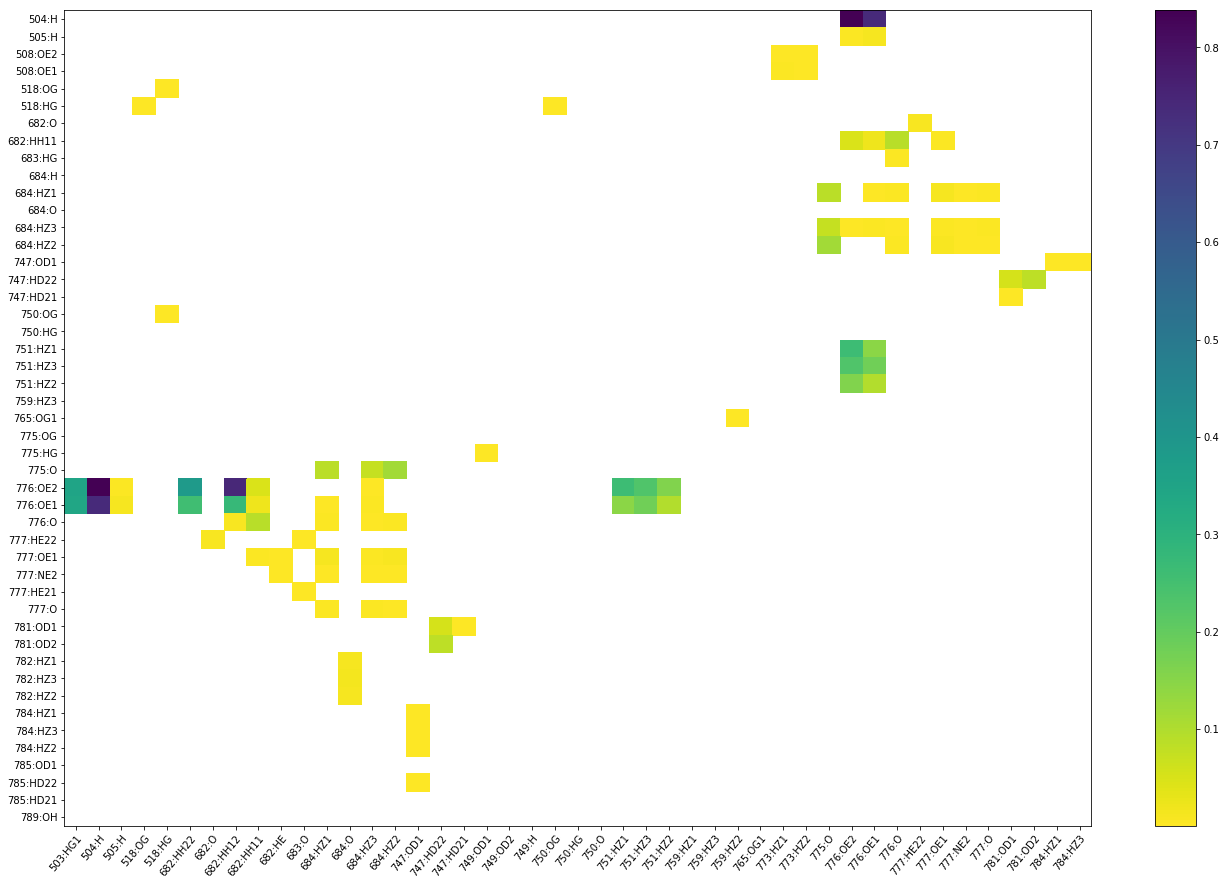

In [7]:

# normalize the matrix to display the stability of hbond during the trjectory analysed
Matrix_inter_hbond_norm = np.around(Matrix_inter_hbond/float(nb_frames_used),decimals=3)
#replace zeros by nan in order to only display colored area only for atoms in interaction 
Matrix_inter_hbond_nan=np.empty(Matrix_inter_hbond_norm.shape)
Matrix_inter_hbond_nan[Matrix_inter_hbond_norm == 0] = 'nan'

fig = plt.figure(figsize=(23, 15))
ax = fig.add_subplot(111)

heatmap= ax.pcolor(Matrix_inter_hbond_nan ,cmap='viridis_r')  

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(Matrix_inter_hbond.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(Matrix_inter_hbond.shape[0])+0.5, minor=False)
ax.invert_yaxis()

#legend and labels
plt.colorbar(heatmap)
column_labels = list_hbond_lect
row_labels = list_hbond_ten
ax.set_xticklabels(column_labels, minor=False, rotation=50,ha="right",rotation_mode='anchor')
ax.set_yticklabels(row_labels, minor=False)

fig.savefig("hbonds_last_avg_inter.svg", dpi=200)


In [8]:
list_stable_hbond_lect=[]
list_stable_hbond_ten=[]

for i in range(len(list_hbond_lect)):
    for j in range(0,len(list_hbond_ten)):
        if Matrix_inter_hbond_norm[j][i] > 0.3:
            print(list_hbond_lect[i]+" - "+list_hbond_ten[j]+" : "+str(Matrix_inter_hbond_norm[j][i]))
            list_stable_hbond_lect.append(list_hbond_lect[i])
            list_stable_hbond_ten.append(list_hbond_ten[j])
            
list_stable_hbond_lect = sorted(set(list_stable_hbond_lect), key=lambda student: int(student.split(':')[0]))
list_stable_hbond_ten = sorted(set(list_stable_hbond_ten), key=lambda student: int(student.split(':')[0]))

#list_stable_hbond_ten = set(list_stable_hbond_ten)

#print list_stable_hbond_lect
#print list_stable_hbond_ten

503:HG1 - 776:OE2 : 0.347
503:HG1 - 776:OE1 : 0.341
504:H - 776:OE2 : 0.838
504:H - 776:OE1 : 0.737
682:HH22 - 776:OE2 : 0.386
682:HH12 - 776:OE2 : 0.746
776:OE2 - 504:H : 0.838
776:OE1 - 504:H : 0.737


In [9]:

# Creates a matrix
w = len(list_stable_hbond_ten)
h = len(list_stable_hbond_lect)
Matrix_inter_hbond_stable = np.zeros((w,h))

for elt in hbond_timeseries[nb_frames_unused:]:
    list_res = elt
    
    for i in list_res:
        resA= i[2][3:]
        resB= i[3][3:]
        
        for j in range(0,len(list_stable_hbond_ten)):
            for k in range(0,len(list_stable_hbond_lect)):
                #print list_res_lect_int01[j]
                #print(list_res_ten_int01[j])   
                if(list_stable_hbond_ten[j]==resA and list_stable_hbond_lect[k]==resB):
                    #print(list_res_ten_int01_sorted[j])
                    #print(list_res_lect_int01_sorted[k])
                    Matrix_inter_hbond_stable[j][k] =  Matrix_inter_hbond_stable[j][k]+1
                    break
                if(list_stable_hbond_ten[j]==resB and list_stable_hbond_lect[k]==resA):
                    #print(list_res_ten_int01_sorted[j])
                    #print(list_res_lect_int01_sorted[k])
                    Matrix_inter_hbond_stable[j][k] =  Matrix_inter_hbond_stable[j][k]+1
                    break
                                


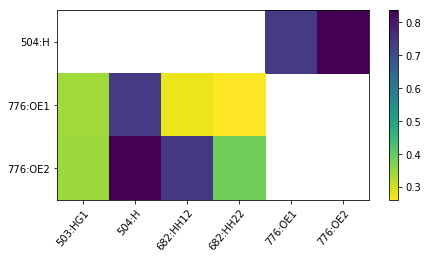

In [20]:
Matrix_inter_hbond_stable_norm = np.around(Matrix_inter_hbond_stable/float(nb_frames_used),decimals=3)
Matrix_inter_hbond_stable_nan=np.around(Matrix_inter_hbond_stable/float(nb_frames_used),decimals=3)
Matrix_inter_hbond_stable_nan[Matrix_inter_hbond_stable_norm == 0] = 'nan'

fig = plt.figure(figsize=(7, 3.5))
ax = fig.add_subplot(111)

heatmap= ax.pcolor(Matrix_inter_hbond_stable_nan ,cmap='viridis_r')  

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(Matrix_inter_hbond_stable_norm.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(Matrix_inter_hbond_stable_norm.shape[0])+0.5, minor=False)
ax.invert_yaxis()

#legend and labels
plt.colorbar(heatmap)
column_labels = list_stable_hbond_lect
row_labels = list_stable_hbond_ten
ax.set_xticklabels(column_labels, minor=False, rotation=50,ha="right",rotation_mode='anchor')
ax.set_yticklabels(row_labels, minor=False)

fig.savefig("hbonds_last_stable_avg_inter.svg", dpi=200)

In [21]:
list_res_lect=[]
for i in list_stable_hbond_lect:
    list_res_lect.append(int(i.split(':')[0]))
list_res_lect=sorted(set(list_res_lect))

list_res_ten=[]
for i in list_stable_hbond_ten:
    list_res_ten.append(int(i.split(':')[0]))
list_res_ten=sorted(set(list_res_ten))


h_bond_stable_avg_dict_lect = {}
for i in list_res_lect:
    h_bond_stable_avg_dict_lect[i]=0 

for i in range(0,len(list_stable_hbond_lect)):
    res_nb = int(list_stable_hbond_lect[i].split(':')[0])
    inter_value = round((Matrix_inter_hbond_stable_norm).sum(axis=0)[i],3)
    h_bond_stable_avg_dict_lect[res_nb]= inter_value+h_bond_stable_avg_dict_lect[res_nb]


h_bond_stable_avg_dict_lect_norm= {k: round(v / max(h_bond_stable_avg_dict_lect.values()),3) for k, v in h_bond_stable_avg_dict_lect.iteritems()} 
print(h_bond_stable_avg_dict_lect_norm)

file_lect_stable = open('inter_prot1_stable.dat','w')

for i in h_bond_stable_avg_dict_lect_norm:
    file_lect_stable.write(str(i)+"\t"+str(h_bond_stable_avg_dict_lect_norm[i])+"\t"+str(h_bond_stable_avg_dict_lect[i])+"\n") 
file_lect_stable.close()

h_bond_stable_avg_dict_ten = {}
for i in list_res_ten:
    h_bond_stable_avg_dict_ten[i]=0 

for i in range(0,len(list_stable_hbond_ten)):
    res_nb = int(list_stable_hbond_ten[i].split(':')[0])
    inter_value = round((Matrix_inter_hbond_stable_norm).sum(axis=1)[i],3)
    h_bond_stable_avg_dict_ten[res_nb]= inter_value+h_bond_stable_avg_dict_ten[res_nb]

h_bond_stable_avg_dict_ten_norm= {k: round(v / max(h_bond_stable_avg_dict_ten.values()),3) for k, v in h_bond_stable_avg_dict_ten.iteritems()} 
print(h_bond_stable_avg_dict_ten_norm)

file_ten_stable = open('inter_prot2_stable.dat','w')

for i in h_bond_stable_avg_dict_ten_norm:
    file_ten_stable.write(str(i)+"\t"+str(h_bond_stable_avg_dict_ten_norm[i])+"\t"+str(h_bond_stable_avg_dict_ten[i])+"\n") 
file_ten_stable.close()


{504: 0.945, 776: 0.945, 682: 1.0, 503: 0.413}
{504: 0.401, 776: 1.0}


In [22]:


max_val_overlap =0
frame=0
counter=nb_frames_unused
for elt in hbond_timeseries[nb_frames_unused:]:
    list_res = elt

    b=[]

    for i in list_res:
        resA= i[2][3:]
        resB= i[3][3:]
        b.append(resA)
        b.append(resB) 

    list_res_hbonds =sorted(set(b))
    overlapping_ten= set(list_res_hbonds) & set(list_stable_hbond_ten)
    overlapping_lect= set(list_res_hbonds) & set(list_stable_hbond_lect)
    overlap_nb= len(overlapping_ten) + len(overlapping_lect) 
    if overlap_nb>=max_val_overlap:
        max_val_overlap=overlap_nb
        frame=counter
        print("frame: "+str(frame)+" +overlap: "+str(max_val_overlap))
    counter=counter+1
    #print list_lect_res_rep
    #print list_ten_res_rep    
    #print list_res_hbonds    
    #print len(overlapping_ten) 
    #print len(overlapping_lect)
    #print("\n\n")
    


frame: 1000 +overlap: 8
frame: 1001 +overlap: 8
frame: 1005 +overlap: 8
frame: 1007 +overlap: 8
frame: 1011 +overlap: 8
frame: 1017 +overlap: 8
frame: 1018 +overlap: 8
frame: 1021 +overlap: 8
frame: 1022 +overlap: 8
frame: 1023 +overlap: 8
frame: 1024 +overlap: 8
frame: 1025 +overlap: 8
frame: 1026 +overlap: 8
frame: 1027 +overlap: 8
frame: 1028 +overlap: 8
frame: 1029 +overlap: 8
frame: 1030 +overlap: 8
frame: 1031 +overlap: 8
frame: 1032 +overlap: 8
frame: 1033 +overlap: 8
frame: 1034 +overlap: 8
frame: 1035 +overlap: 8
frame: 1036 +overlap: 8
frame: 1037 +overlap: 8
frame: 1038 +overlap: 8
frame: 1039 +overlap: 8
frame: 1040 +overlap: 8
frame: 1041 +overlap: 8
frame: 1042 +overlap: 8
frame: 1043 +overlap: 8
frame: 1044 +overlap: 8
frame: 1045 +overlap: 8
frame: 1046 +overlap: 8
frame: 1047 +overlap: 8
frame: 1048 +overlap: 8
frame: 1049 +overlap: 8
frame: 1050 +overlap: 8
frame: 1051 +overlap: 8
frame: 1052 +overlap: 8
frame: 1053 +overlap: 8
frame: 1054 +overlap: 8
frame: 1055 +ove

frame: 4754 +overlap: 9
frame: 4755 +overlap: 9
frame: 4761 +overlap: 9
frame: 4766 +overlap: 9
frame: 4767 +overlap: 9
frame: 4769 +overlap: 9
frame: 4771 +overlap: 9
frame: 4777 +overlap: 9
frame: 4780 +overlap: 9
frame: 4781 +overlap: 9
frame: 4785 +overlap: 9
frame: 4788 +overlap: 9
frame: 4791 +overlap: 9
frame: 4793 +overlap: 9
frame: 4794 +overlap: 9
frame: 4795 +overlap: 9
frame: 4796 +overlap: 9
frame: 4799 +overlap: 9
frame: 4805 +overlap: 9
frame: 4808 +overlap: 9
frame: 4809 +overlap: 9
frame: 4811 +overlap: 9
frame: 4814 +overlap: 9
frame: 4817 +overlap: 9
frame: 4820 +overlap: 9
frame: 4822 +overlap: 9
frame: 4825 +overlap: 9
frame: 4826 +overlap: 9
frame: 4829 +overlap: 9
frame: 4830 +overlap: 9
frame: 4831 +overlap: 9
frame: 4832 +overlap: 9
frame: 4833 +overlap: 9
frame: 4836 +overlap: 9
frame: 4838 +overlap: 9
frame: 4839 +overlap: 9
frame: 4842 +overlap: 9
frame: 4847 +overlap: 9
frame: 4849 +overlap: 9
frame: 4852 +overlap: 9
frame: 4853 +overlap: 9
frame: 4855 +ove

In [13]:
for i in hbond_timeseries[5000]:
    print(i[2:4])

['THR503:HG1', 'GLU776:OE1']
['THR503:HG1', 'GLU776:OE2']
['LEU504:H', 'GLU776:OE2']
['ARG682:HH12', 'GLU776:OE2']
['ARG682:HH22', 'GLU776:OE2']
['LYS751:HZ2', 'GLU776:OE1']
['LYS751:HZ2', 'GLU776:OE2']
